
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 重み減少

:label: `sec_weight_decay`

過学習の問題を特徴づけたので、最初の*正則化*手法を導入できます。より多くのトレーニング データを収集することで、いつでも過学習を軽減できることを思い出してください。ただし、それにはコストがかかり、時間がかかる場合や、完全に制御不能な場合があり、短期的には不可能になります。現時点では、リソースが許す限りの高品質データをすでに持っていると想定し、データセットが所与のものであるとしても、自由に使えるツールに焦点を当てることができます。

多項式回帰の例 (:numref: `subsec_polynomial-curve-fitting` ) では、近似された多項式の次数を微調整することでモデルの容量を制限できたことを思い出してください。実際、特徴の数を制限することは、過剰適合を軽減するための一般的な手法です。ただし、単に機能を無視すると、道具が鈍くなりすぎる可能性があります。多項式回帰の例にこだわり、高次元の入力で何が起こるかを考えてみましょう。多変量データへの多項式の自然な拡張は*単項式*と呼ばれます。これは単に変数のべき乗の積です。単項式の次数はべき乗の和です。たとえば、$x_1^2 x_2$ と $x_3 x_5^2$ は両方とも 3 次の単項式です。

 $d$ が大きくなるにつれて、次数 $d$ の項の数が急速に増加することに注意してください。 $k$ 変数が与えられた場合、次数 $d$ の単項式 (つまり、$k$ multichoose $d$) の数は ${k - 1 + d} \choose {k - 1}$ です。たとえば 2 ドルから 3 ドルへの程度の小さな変化でさえ、モデルの複雑さは劇的に増加します。したがって、関数の複雑さを調整するためのよりきめの細かいツールが必要になることがよくあります。


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


## 規範と重み減少

(***重み減衰 は*、パラメーターの数を直接操作するのではなく、パラメーターが取り得る値を制限することによって機能します。** ) ミニバッチの確率的勾配降下法によって最適化された場合、深層学習サークルの外では $\ell_2$ 正則化と呼ばれるより一般的に、重み減衰は次のようになります。パラメトリック機械学習モデルを正規化するために最も広く使用されている手法。この手法は、すべての関数 $f$ の中で、関数 $f = 0$ (すべての入力に値 $0$ を割り当てる) が、ある意味で最も*単純で*あり、関数の複雑さを測定できるという基本的な直観によって動機付けられています。パラメータのゼロからの距離によって決まります。しかし、関数とゼロの間の距離をどのくらい正確に測定すべきでしょうか?単一の正解はありません。実際、関数解析やバナッハ空間の理論の一部を含む数学の分野全体が、そのような問題の解決に専念しています。

 1 つの単純な解釈は、線形関数 $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$ の複雑さを、その重みベクトルのノルム ($| など) によって測定することかもしれません。 \mathbf{w} |^2$。 $\ell_2$ ノルムと $\ell_1$ ノルムを導入したことを思い出してください。これらは、 :numref: `subsec_lin-algebra-norms`のより一般的な $\ell_p$ ノルムの特殊なケースです。小さな重みベクトルを保証するための最も一般的な方法は、そのノルムを損失を最小化する問題にペナルティ項として追加することです。したがって、*トレーニング ラベルの予測損失を最小化する*という元の目標を、*予測損失とペナルティ項の合計を最小化する*新しい目標に置き換えます。ここで、重みベクトルが大きくなりすぎる場合、学習アルゴリズムは重みノルムを最小化することに重点を置く可能性があります。 \mathbf{w} |^2$ とトレーニング誤差を最小限に抑えること。まさにそれが私たちが望んでいることです。コードで説明するために、線形回帰の :numref: `sec_linear_regression`から前の例を復活させます。そこで私たちの損失は、

 $$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \ mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

 $\mathbf{x}^{(i)}$ は特徴、$y^{(i)}$ は任意のデータ例 $i$ のラベル、$(\mathbf{w}, b) であることを思い出してください。 $ はそれぞれ重みパラメータとバイアスパラメータです。重みベクトルのサイズにペナルティを与えるには、何らかの方法で $| を追加する必要があります。 \mathbf{w} |^2$ を損失関数に適用しますが、モデルはこの新しい追加ペナルティと標準損失をどのようにトレードオフすべきでしょうか?実際には、検証データを使用して近似した非負のハイパーパラメータである*正則化定数*$\lambda$ を介してこのトレードオフを特徴付けます。

 $$L(\mathbf{w}, b) + \frac{\lambda}{2} |\mathbf{w}|^2.$$

 $\lambda = 0$ の場合、元の損失関数を回復します。 $\lambda &gt; 0$ の場合、$| のサイズを制限します。 \mathbf{w} |$。慣例に従って $2$ で除算します。二次関数の導関数を取得すると、$2$ と $1/2$ が相殺され、更新の式が見栄えよくシンプルになることが保証されます。賢明な読者は、なぜ標準ノルム (つまりユークリッド距離) ではなく二乗ノルムを扱うのか疑問に思うかもしれません。これは計算上の便宜のために行われます。 $\ell_2$ ノルムを 2 乗することで平方根を削除し、重みベクトルの各成分の二乗和を残します。これにより、ペナルティの導関数の計算が容易になります。導関数の合計は合計の導関数と等しくなります。

さらに、なぜ最初に $\ell_1$ ノルムではなく $\ell_2$ ノルムを扱うのかと疑問に思うかもしれません。実際、他の選択肢も有効であり、統計全体で人気があります。 $\ell_2$-正則化線形モデルは古典的な*リッジ回帰*アルゴリズムを構成しますが、$\ell_1$-正則化線形回帰は同様に統計学の基本的な手法であり、一般に*ラッソ回帰*として知られています。 $\ell_2$ ノルムを使用する理由の 1 つは、重みベクトルの大きな成分に大きなペナルティが課されるためです。これにより、学習アルゴリズムは、より多くの特徴にわたって重みを均等に分散するモデルに偏ります。実際には、これにより、単一変数の測定誤差に対してより堅牢になる可能性があります。対照的に、$\ell_1$ ペナルティは、他の重みをゼロにクリアすることによって、小さな特徴セットに重みを集中させるモデルをもたらします。これにより、*特徴選択*のための効果的な方法が得られますが、これは他の理由から望ましい場合もあります。たとえば、モデルがいくつかの機能のみに依存している場合、他の (削除された) 機能のデータを収集、保存、送信する必要がない可能性があります。

 :eqref: `eq_linreg_batch_update`で同じ表記を使用すると、 $\ell_2$ 正規化回帰のミニバッチ確率的勾配降下更新は次のようになります。

 $$\begin{aligned} \mathbf{w} &amp; \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_ {i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{( i)}\右)。 \end{整列}$$

前と同様に、推定値が観測値と異なる量に基づいて $\mathbf{w}$ を更新します。ただし、$\mathbf{w}$ のサイズもゼロに向かって縮小します。このため、この方法は「重み減衰」と呼ばれることがあります。ペナルティ項のみを考慮すると、最適化アルゴリズムはトレーニングの各ステップで重みを*減衰させます*。特徴選択とは対照的に、重み減衰は、関数の複雑さを調整するための継続的なメカニズムを提供します。 $\lambda$ の値が小さいほど $\mathbf{w}$ の制約が少なくなり、$\lambda$ の値が大きいほど $\mathbf{w}$ の制約が大きくなります。対応するバイアス ペナルティ $b^2$ を含めるかどうかは実装によって異なり、ニューラル ネットワークの層によっても異なる場合があります。多くの場合、バイアス項は正規化されません。さらに、$\ell_2$ の正則化は他の最適化アルゴリズムの重み減衰と同等ではないかもしれませんが、重みのサイズを縮小することによる正則化の考え方は依然として当てはまります。

## 高次元線形回帰

簡単な合成例を通じて、重量減衰の利点を説明します。

まず、[**以前と同様にいくつかのデータを生成]します**。

 **( $$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ ここで } \epsilon \sim \mathcal{N}(0, 0.01^2).$$ )**

この合成データセットでは、ラベルは入力の基礎となる線形関数によって与えられ、平均が 0、標準偏差が 0.01 のガウス ノイズによって破損されます。説明の目的で、問題の次元を $d = 200$ に増やし、サンプル数が 20 のみの小さなトレーニング セットを扱うことで、過学習の影響を顕著にすることができます。


In [2]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)


## ゼロからの実装

ここで、重み減衰を最初から実装してみましょう。ミニバッチの確率的勾配降下法がオプティマイザーであるため、元の損失関数に $\ell_2$ ペナルティの 2 乗を追加するだけで済みます。

###  ( **$\ell_2$ ノルムペナルティの定義**)

おそらく、このペナルティを実装する最も便利な方法は、すべての項を二乗して合計することです。


In [3]:
def l2_penalty(w):
    return (w ** 2).sum() / 2


### モデルの定義

最終モデルでは、線形回帰と二乗損失は :numref: `sec_linear_scratch`以来変わっていないため、 `d2l.LinearRegressionScratch`のサブクラスを定義するだけです。ここでの唯一の変更は、損失にペナルティ期間が含まれるようになったことです。


In [4]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))


次のコードは、20 個の例を含むトレーニング セットでモデルを適合させ、100 個の例を含む検証セットでそれを評価します。


In [5]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))


### [**正規化を行わないトレーニング**]

次に、このコードを`lambd = 0`で実行し、重み減衰を無効にします。過剰適合がひどく、トレーニング誤差は減少しますが、検証誤差は減少しないことに注意してください。これは教科書的な過剰適合のケースです。


L2 norm of w: 0.00984874926507473


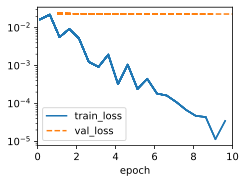

In [6]:
train_scratch(0)


### [**ウェイトディケイを使用する**]

以下では、大幅な重量減衰を伴って実行します。トレーニング誤差は増加しますが、検証誤差は減少することに注意してください。これはまさに正則化から期待される効果です。


L2 norm of w: 0.0013237446546554565


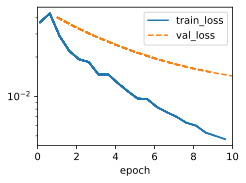

In [7]:
train_scratch(3)


## [**簡潔な実装**]

重み減衰はニューラル ネットワークの最適化において遍在しているため、ディープ ラーニング フレームワークは重み減衰を最適化アルゴリズム自体に統合し、損失関数と組み合わせて簡単に使用できるようにすることで、特に便利にします。さらに、この統合により計算上の利点がもたらされ、追加の計算オーバーヘッドを発生させることなく、実装トリックによってアルゴリズムに重み減衰を追加できるようになります。更新の重み減衰部分は各パラメーターの現在の値にのみ依存するため、オプティマイザーはいずれにせよ各パラメーターを 1 回操作する必要があります。



次のコードでは、オプティマイザーをインスタンス化するときに、 `weight_decay`を通じて重み減衰ハイパーパラメーターを直接指定します。デフォルトでは、PyTorch は重みとバイアスの両方を同時に減衰しますが、異なるポリシーに従って異なるパラメーターを処理するようにオプティマイザーを構成できます。ここでは、重み ( `net.weight`パラメーター) に対して`weight_decay`のみを設定するため、バイアス ( `net.bias`パラメーター) は減衰しません。


In [8]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)


[**プロットは、重み減衰を最初から実装したときのプロットに似ています**]。ただし、このバージョンはより高速に実行され、実装が容易です。その利点は、より大きな問題に対処し、この作業がより日常的になるにつれてより顕著になります。


L2 norm of w: 0.013002106919884682


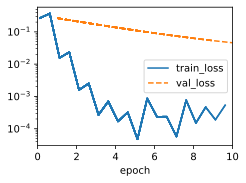

In [9]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))


これまでのところ、単純な一次関数を構成する概念については 1 つだけ触れてきました。さらに、単純な非線形関数を構成するものはさらに複雑な問題になる可能性があります。たとえば、[カーネル ヒルベルト空間 (RKHS) を再現すると、](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)線形関数用に導入されたツールを非線形コンテキストで適用できるようになります。残念ながら、RKHS ベースのアルゴリズムは、大規模な高次元データへの拡張性が低い傾向があります。本書では、重み減衰を深いネットワークのすべての層に適用するという一般的なヒューリスティックを頻繁に採用します。

## まとめ

正則化は、過学習に対処するための一般的な方法です。古典的な正則化手法では、学習されたモデルの複雑さを軽減するために (トレーニング時に) 損失関数にペナルティ項を追加します。モデルをシンプルに保つための特別な選択肢の 1 つは、$\ell_2$ ペナルティを使用することです。これは、ミニバッチ確率的勾配降下法アルゴリズムの更新ステップで重みの減衰につながります。実際には、重み減衰機能は深層学習フレームワークのオプティマイザーで提供されます。パラメータのセットが異なると、同じトレーニング ループ内で更新動作が異なる場合があります。

## 演習
1. このセクションの推定問題で $\lambda$ の値を試してください。トレーニングと検証の精度を $\lambda$ の関数としてプロットします。何を観察しますか?
1. 検証セットを使用して、$\lambda$ の最適な値を見つけます。本当に最適値なのでしょうか？これは重要ですか?
1.  $|\mathbf{w}|^2$ の代わりに $\sum_i |w_i|$ を選択したペナルティ ($\ell_1$ 正則化) として使用した場合、更新方程式はどのようになりますか?
1.  $|\mathbf{w}|^2 = \mathbf{w}^\top \mathbf{w}$ であることがわかっています。行列の同様の方程式を見つけることができますか ( :numref: `subsec_lin-algebra-norms`のフロベニウス ノルムを参照)。
1. トレーニング誤差と汎化誤差の関係を確認します。重みの減衰、トレーニングの増加、適切な複雑さのモデルの使用に加えて、過学習に対処するために他にどのような方法が考えられますか?
1. ベイズ統計では、$P(w \mid x) \propto P(x \mid w) P(w)$ を介して事後確率に到達する事前確率と尤度の積を使用します。正則化を使用して $P(w)$ を識別するにはどうすればよいでしょうか?



[ディスカッション](https://discuss.d2l.ai/t/99)
